# Population activity

In [1]:
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../presentation')) # include path with style
sys.path.append(os.path.abspath('../simulation/')) # include path with simulation specifications
import pres_style as style; reload(style)

# Import specific moduls
#import network_params; reload(network_params)
import model_class; reload(model_class)
import sim_params as sim; reload(sim)
%matplotlib inline

show_fig = False
save_fig = True
picture_format = ".pdf"
xfactor = 2.6
style.rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83) 
figure_path = os.path.join(".", "figures")

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)
plotting = True

In [2]:
# DATA
data_file = "micro"
data_sup_path = "/export/data-schuessler/data_microcircuit/"
data_path = os.path.join(data_sup_path, data_file)
sim_spec = "a1.0_t300.2_totalN_00"

# Original data
file_name  = sim_spec + ".hdf5"  
res_file_name = sim_spec + "_res.hdf5"

### Basic data

In [3]:
# Open file: data
data_file = h5py.File(os.path.join(data_path, file_name), "r")

# Simulation attributes
area    = data_file.attrs["area"]   
t_sim   = data_file.attrs["t_sim"]  
t_trans = data_file.attrs["t_trans"]
dt      = data_file.attrs["dt"]    
populations   = data_file.attrs["populations"].astype("|U4")
layers        = data_file.attrs["layers"].astype("|U4")        
types         = data_file.attrs["types"].astype("|U4")     
n_populations = data_file.attrs["n_populations"]
n_layers      = data_file.attrs["n_layers"]       
n_types       = data_file.attrs["n_types"] 

t_measure = t_sim - t_trans


# labels & colors: need to be adapted if n_types != (e, i)
layer_colors = style.colors[:n_layers]
colors = np.array([color for color in layer_colors for i in range(n_types)])
colors[1::2] = colors[1::2] * 0.4   #### adapt for more than two types!
if reverse_order:
    populations = populations[::-1]
    layers = layers[::-1]
    types = types[::-1]
    colors = colors[::-1]
data_file.close()

## Spike counts and power spectrum

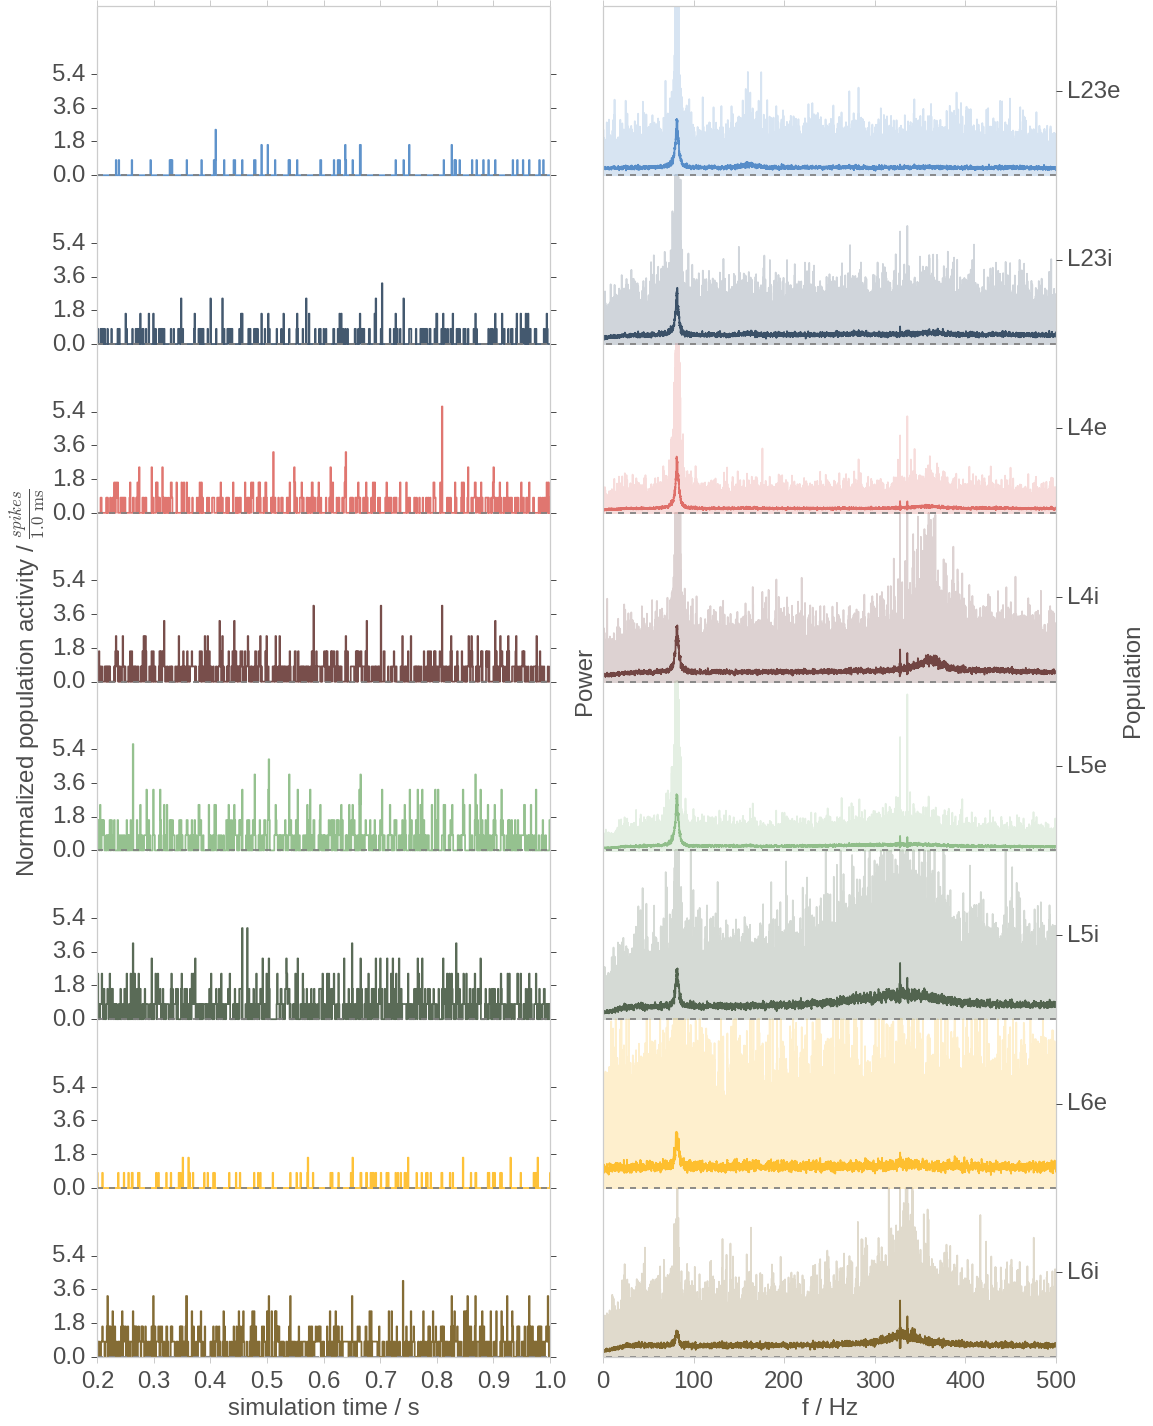

In [5]:
from scipy.signal import savgol_filter as sav
def rebin(array, n_zoom=2):
    """Rebinning of an array without interpolation."""
    overlap = array.shape[-1] % n_zoom
    if overlap != 0:
        pre_rebin = array[:, :-overlap].copy() # cut off the end
    else:
        pre_rebin = array.copy()

    rebinned = pre_rebin[:, ::n_zoom]
    for k in range(1, n_zoom):
        rebinned += pre_rebin[:, k::n_zoom]

    return rebinned, overlap

# Open file: results
with h5py.File(os.path.join(data_path, res_file_name), "r") as res_file:
    res_grp = res_file[sim_spec2]
    n_rec_spikes = res_grp["n_rec_spikes"][:]
    hist_spikes  = res_grp["hist_spikes"][:]
    hist_times   = res_grp["hist_times"][:]
    normed_hist = (hist_spikes.T / n_rec_spikes).T

fig = plt.figure(figsize=(xfactor*6.2, 2*xfactor*3.83) )
ax0 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax1 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

# Rebinning
n_zoom = 10 # factor by which to zoom out
reb_hist, overlap = rebin(normed_hist, n_zoom=n_zoom)
stretch = np.floor(1. / np.max(reb_hist))  # stretch each histogram...  
time_step = dt * 1.e-3 # s

for i, population in enumerate(populations):
    if overlap == 0:
        reb_hist_times = hist_times[::n_zoom]
    else:
        reb_hist_times = hist_times[:-overlap][::n_zoom]
    ax0.plot(reb_hist_times, stretch * reb_hist[i] + i, 
             "-", alpha=0.8, color=colors[i], drawstyle="steps")
    ax0.plot(hist_times[[0, -1]], [i]*2, "--", color="gray")
    
    # Power spectrum
    glob_ac = reb_hist[i]
    ga_mean = np.mean(glob_ac)

    ps = np.abs(np.fft.fft(glob_ac - ga_mean))**2
    freqs = np.fft.fftfreq(glob_ac.size, time_step * n_zoom)
    idx = np.argsort(freqs)

    # Filtered
    filtered = sav(ps[idx], 301, 5, deriv=0, delta=1.0, axis=-1, mode='interp', cval=0.0)
    
    # Normalize
    y_max = 3 * np.max(filtered)
    ps_norm = ps[idx] / y_max
    ps_norm[ps_norm > 1] = 1
    filtered_norm = filtered / y_max   
    
    ax1.plot(freqs[idx], ps_norm + i, "-", alpha=0.2, color=colors[i], label=population)
    ax1.plot(freqs[idx], filtered_norm + i, "-", alpha=0.8, color=colors[i])    
    ax1.plot(freqs[idx][[0, -1]], [i]*2, "--", color="gray")
    
xlim = (t_min_raster, t_max_raster)    

# Normalized pop activity ticks
ax0.set_xlim(*xlim)
ax0.set_xlabel('simulation time / s')
ax0.set_ylim(0, n_populations)
ax0.set_ylabel('Normalized population activity / $\\frac{spikes}{%.1f \,\mathrm{ms}}$'%(0.1*n_zoom))
# Axes labels
n_ticks = 5
yto           = np.arange(0, 1 - 1. / n_ticks, 1. / n_ticks)
yt_offset     = np.repeat(np.arange(0, n_populations), n_ticks-1)
y_ticks = np.tile(yto, n_populations) + yt_offset
y_ticklabels = np.tile(np.arange(0, stretch * (1 - 1. / n_ticks), stretch / n_ticks), n_populations)
ax0.set_yticks(y_ticks)
ax0.set_yticklabels(y_ticklabels)
ax0.grid(False)

# No ticks!
ax1.set_xlabel('f / Hz')
xlim = (0, 500)
ax1.set_xlim(*xlim)
ax1.set_yticks([])
ax1.set_ylabel("Power")
ax1.set_ylim(0, n_populations)
ax1.grid(False)
#ax2.legend(loc='best')

# Population labels
ax2 = ax1.twinx()
ax2.set_ylabel('Population')
ax2.set_yticks(np.arange(0.5, 8, 1))
ax2.set_yticklabels(populations)
ax2.set_ylim(0, n_populations)
ax2.grid(False)

for ax in fig.axes:
    style.fixticks(ax)
fig_name = "population_activity_" + sim_spec + "_" + sim_spec2

if save_fig:
    fig.savefig(os.path.join(figure_path, fig_name + picture_format))
else:
    suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
    suptitle += '\nfile: ' + os.path.join(sim_spec, sim_spec2)
    fig.suptitle(suptitle, y=0.98)  